In [2]:
with open("./names.txt", "r") as file:
    words = file.read().split("\n")
len(words)

32033

In [2]:
import random

class TrigramCounter:
    
    def __init__(self, key:str):
        self.key = key
        self.counts = {}
        
    def incr(self, key):
        if key not in self.counts:
            self.counts[key] = 1
        else:
            self.counts[key] += 1
    
    def selection(self):
        return random.choices(list(self.counts.keys()), weights=self.counts.values(), k=1)[0]


c = TrigramCounter("ab")
c.incr('b')
c.incr('b')
c.incr('b')
c.incr('b')
c.incr('b')

c.incr('a')
c.incr('a')
c.incr('a')

c.incr('c')

c.incr('d')

counter = BigramCounter("aa")

for i in range(10000):
    counter.incr(c.selection())

counter.counts

NameError: name 'BigramCounter' is not defined

In [180]:
class Trigram:
    
    def __init__(self):
        
        self.counters = {}
        
    def add_word(self, word:str):
        for i in range(2, len(word)):
            key = word[i-2:i]
            value = word[i]
            if key not in self.counters:
                self.counters[key] = TrigramCounter(key)
            self.counters[key].incr(value)
        end_key = word[len(word)-2:]
        if end_key not in self.counters:
            self.counters[end_key] = TrigramCounter(end_key)
        self.counters[end_key].incr("")
    
    def emit(self, prefix:str):
        key = prefix[-2:]
        if key in self.counters:
            return self.counters[key].selection()
        else:
            return ""


start_tokens = '00'
        
model = Trigram()
for word in words:
    model.add_word(start_tokens + word)
    

name = start_tokens
for i in range(5):
    next_char = model.emit(name)
    if next_char == "":
        break
    name += next_char
    
print(name[2:])

osbel


In [64]:
import torch

N = torch.zeros((28,28), dtype=torch.int32)

start_token = '<s>'
end_token = '<e>'

token_lookup = {k:i for i, k in enumerate("abcdefghijklmnopqrstuvwxyz")}
token_lookup[start_token] = 26
token_lookup[end_token] = 27

char_lookup = {token_lookup[k]:k for k in token_lookup}

token_lookup

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<s>': 26,
 '<e>': 27}

In [4]:
for sword in words:
    word = [start_token] + list(sword) + [end_token]
    for i in range(2, len(word)):
        c1, c2 = (token_lookup[c] for c in word[i-1:i+1])
        N[c1,c2] += 1

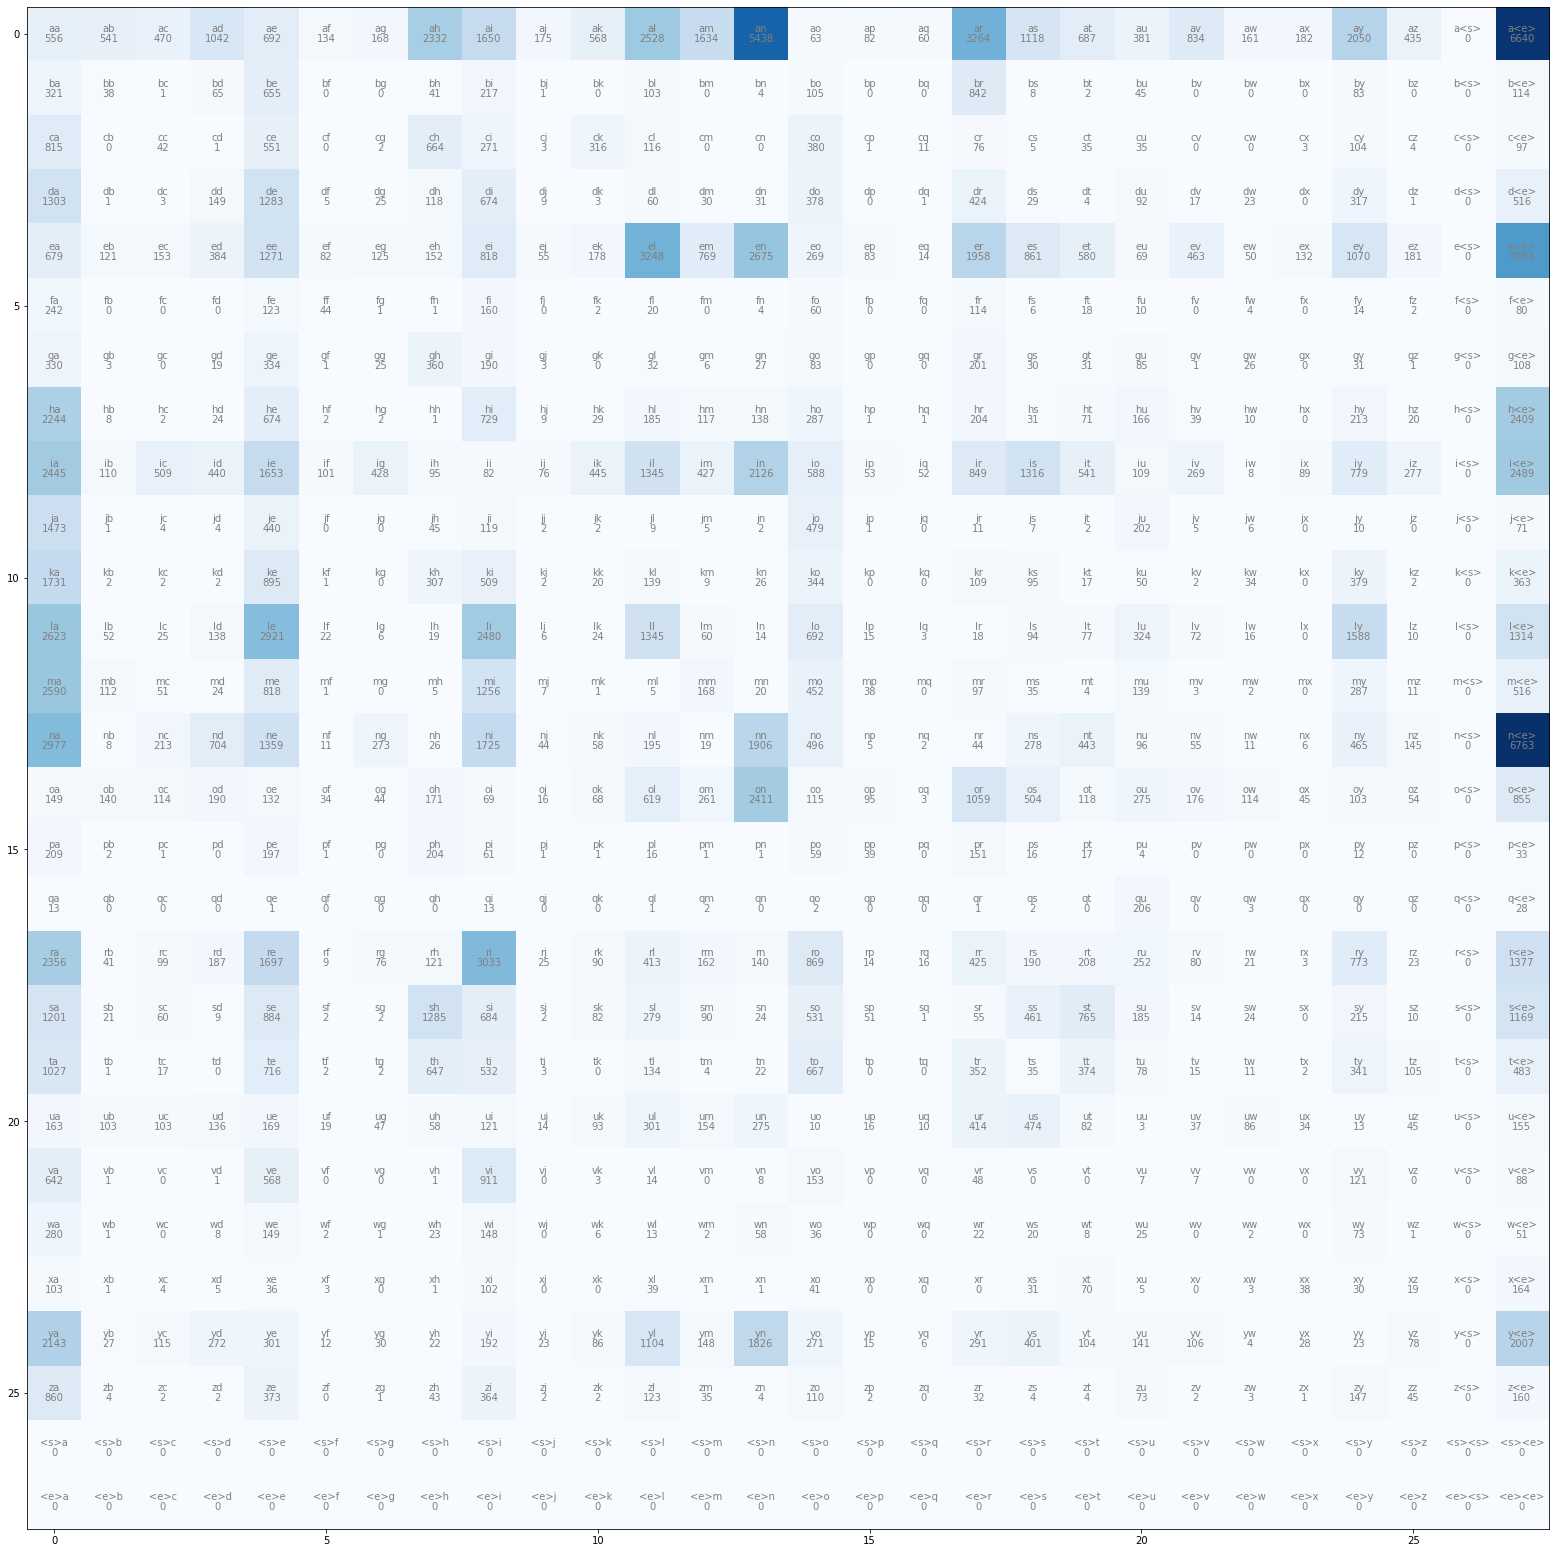

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(28,28))
plt.imshow(N, cmap='Blues')

for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        ch_str = char_lookup[i] + char_lookup[j]
        plt.text(j, i, ch_str, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
        

In [6]:
g = torch.Generator().manual_seed(2147483647)
p = N[26].float()
p = p / p.sum()
p

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan])

In [9]:
P = N.float()
P = P / P.sum(dim=1, keepdim=True)
P.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,    nan,
           nan])

In [160]:

class NGramModel:
    
    def __init__(self, n:int, w:int, token_table:dict, start_token:int, end_token:int):
        
        self.n = n
        self.w = w
        self.token_table = token_table
        self.start_token = start_token
        self.end_token = end_token
        self.N = torch.zeros([w] * n, dtype=torch.int16)
        
    def tokenize_word(self, word:str):
        return ([self.start_token] * (self.n - 1)) + [self.token_table[c] for c in list(word)] + ([self.end_token] * (self.n - 1))
        
    def add_word(self, word:str):
        tokens = self.tokenize_word(word)
        for i in range(self.n, len(tokens)+1):
            self.N[tuple(tokens[i-self.n:i])] += 1
    
    def add_words(self, words:list, smoothing:float = 1.):
        for word in words:
            self.add_word(word)
        self.P = self.N.float() + smoothing
        self.P /= self.P.sum(dim=-1, keepdim=True)
            
    def sample(self, tokens:list=None, q:int=64):
        on = self.n - 1
        if tokens is None:
            tokens = [self.start_token] * on
        while q > 0:
            ix = torch.multinomial(self.P[tuple(tokens[-on:])], num_samples=1, replacement=True).item()
            tokens.append(ix)
            if ix == self.end_token:
                break
            q -= 1
        return tokens[on-1:]
    
    def calc_log_likelihood(self, word:str):
        tokens = self.tokenize_word(word)
        log_likelihood = 0.
        for i in range(self.n, len(tokens)+1):
            prob = self.P[tuple(tokens[i-self.n:i])]
            log_likelihood += torch.log(prob)
        return log_likelihood
            
        

In [189]:
model = NGramModel(5, 28, token_lookup, 26, 27)
model.add_words(words, smoothing=0)
model.sample()

[26, 19, 7, 4, 14, 3, 14, 17, 4, 27]

In [190]:
for i in range(20):
    name = "".join(char_lookup[x] for x in model.sample()[1:-1])
    name = name[0].upper() + name[1:]
    print(name)

Jaylie
Jasiyah
Sosefina
Emani
Thaline
Lyssa
Diquan
Kiyana
Victoryn
Doriano
Sosa
Demeryna
Wylde
Jaydyn
Shiloh
Raii
Jibrily
Yeva
Xylon
Marke


In [191]:
for name in words[:5]:
    print(f'{name}: ({model.calc_log_likelihood(name):.4f})')

emma: (-8.6928)
olivia: (-9.6579)
ava: (-9.6814)
isabella: (-9.4385)
sophia: (-8.9527)


In [187]:
log_likelihood = 0.
for word in words:
    log_likelihood += model.calc_log_likelihood(name)
print(f'Average negative Log Likelihood: {-log_likelihood/len(words)}')

Average negative Log Likelihood: 26.4809627532959


In [22]:
with open('./karpathy/book.txt', 'r') as f:
    book_text = f.read()
    
start_token = '<bos>'
end_token = '<eos>'

book_characters = set(book_text)

book_token_lookup = {k:i+1 for i, k in enumerate(book_characters)}
book_token_lookup[start_token] = 0
book_token_lookup[end_token] = len(book_characters) + 1
book_character_lookup = {i:k for k, i in book_token_lookup.items()}

book_model = NGramModel(5, len(book_characters) + 2, book_token_lookup, 0, len(book_characters) + 1)
book_model.add_words([book_text])

In [23]:
print("".join(book_character_lookup[x] for x in book_model.sample(q=256)))

<bos>The sought law in writted States are that required Ellis. How couldn't me, memora, but hesitation, who warn move to provide a commercially drifted I could print entities of thing?" Dixon had living of the jolts.

"Don't know
it's going as
internations may 


In [64]:
import re

cleaned_book_text = book_text.lower().replace("\n"," ")
cleaned_book_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', cleaned_book_text)
book_words = [token for token in cleaned_book_text.split(" ") if token != ""]
book_word_tokens = set(book_word_tokens)

book_word_token_lookup = {k:i+1 for i, k in enumerate(book_word_tokens)}
book_word_token_lookup[start_token] = 0
book_word_token_lookup[end_token] = len(book_word_tokens) + 1
book_word_lookup = {i:k for k, i in book_word_token_lookup.items()}

book_word_model = NGramModel(3, len(book_word_tokens) + 2, book_word_token_lookup, 0, len(book_word_tokens) + 1)
book_word_model.add_words([book_words])

In [65]:
prompt = "my man has a"
tokens = [book_word_token_lookup[x] for x in prompt.split(" ")]
print(" ".join(book_word_lookup[x] for x in book_word_model.sample(tokens=tokens)))

man has a habit of becoming the very new in science retorted dixon but we were disastrously entrapped this ape species has no true intelligence but they have instincts of surpassing nervous intensity instincts of surpassing nervous intensity instincts of greed and lust and hatred and that bestial nervous influence warped the symbiosis is not so inhibited and can still remember its own past maybe wordsworth was


__Goal:__  Maximize the likelihood W.R.T. parameters of model
* Which is equivilant to maximizing log likelihood (due to log likelihood being monotonic function)
* Which is equivilant to minimizing negative log likelihood
* Which is equivilant to minimizing average negative log likelihood

### Neural Network Approach

In [44]:
xs, ys = [], []

for word in words:
    chs = ["<s>"] + list(word) + ["<e>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = token_lookup[ch1]
        ix2 = token_lookup[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [45]:
import torch.nn.functional as F

total_tokens = len(token_lookup.keys())

xs_enc = F.one_hot(xs, num_classes=total_tokens).float()
ys_enc = F.one_hot(ys, num_classes=total_tokens).float()

In [47]:
xs_enc.shape

torch.Size([228146, 28])

In [48]:
# random normal distribution for weights, 28 inputs with 28 neurons (for 28 class outputs)
W = torch.randn((total_tokens, total_tokens), requires_grad=True)
# (N x 28) @ (28 x 28) -> (N x 28)
# firing rate for the 13th neuron on the 3rd input, achieved by a dot product of the 3rd input one hot matrix and neuron weights matrix
(xs_enc @ W)[3,13], (xs_enc[3] * W[:,13]).sum()

(tensor(0.3710, grad_fn=<SelectBackward0>),
 tensor(0.3710, grad_fn=<SumBackward0>))

In [37]:
# interpret each of the weights as log counts, and then exponentiate them
logits = (xs_enc @ W)
# perform soft max
counts = logits.exp() # equivilant to N tensor
probs = counts / counts.sum(dim=-1, keepdims=True)
probs

# each of these operations are differentiable, meaning we can back propogate through them

tensor([[0.0209, 0.0446, 0.0152, 0.1482, 0.0715, 0.0708, 0.0126, 0.1483, 0.0179,
         0.0017, 0.0085, 0.0294, 0.0368, 0.0618, 0.0083, 0.0788, 0.0366, 0.0043,
         0.0562, 0.0135, 0.0228, 0.0189, 0.0065, 0.0042, 0.0157, 0.0098, 0.0295,
         0.0067],
        [0.0045, 0.0101, 0.0411, 0.0461, 0.0104, 0.0170, 0.0141, 0.0707, 0.0061,
         0.0329, 0.0107, 0.0318, 0.0052, 0.0777, 0.0309, 0.0098, 0.0276, 0.0221,
         0.1114, 0.1142, 0.0620, 0.0292, 0.0321, 0.0261, 0.0320, 0.0805, 0.0294,
         0.0141],
        [0.0302, 0.0117, 0.1945, 0.0047, 0.0186, 0.0114, 0.0891, 0.0340, 0.0125,
         0.0282, 0.0458, 0.0051, 0.0101, 0.0093, 0.0301, 0.0387, 0.0155, 0.0018,
         0.0190, 0.0094, 0.0422, 0.0217, 0.0128, 0.0268, 0.0173, 0.0996, 0.0295,
         0.1303],
        [0.0302, 0.0117, 0.1945, 0.0047, 0.0186, 0.0114, 0.0891, 0.0340, 0.0125,
         0.0282, 0.0458, 0.0051, 0.0101, 0.0093, 0.0301, 0.0387, 0.0155, 0.0018,
         0.0190, 0.0094, 0.0422, 0.0217, 0.0128, 0.0268

In [39]:

lr = 0.1

loss = -(probs[(torch.arange(xs_enc.shape[0], dtype=torch.long), ys.long())]).log().mean()
W.grad = None
loss.backward()
W.data += W.grad * -lr

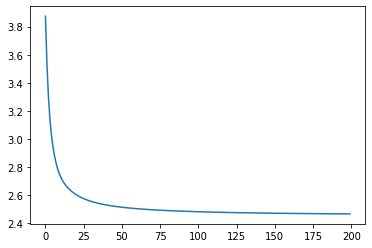

In [56]:
history = []

W = torch.randn((total_tokens, total_tokens), requires_grad=True)

lr = 40

for i in range(200):
    
    W.grad = None

    logits = (xs_enc @ W)
    
    counts = logits.exp()
    probs = counts / counts.sum(dim=-1, keepdims=True)
    
    loss = -(probs[torch.arange(xs_enc.shape[0], dtype=torch.long), ys.long()]).log().mean()
    
    history.append(loss.item())
    
    loss.backward()
    
    W.data += W.grad * -lr
    
plt.plot(history)

In [135]:

def gen_name(weights):
    max_length = 25
    name = [token_lookup[start_token]]
    while max_length:
        name_one_hot = F.one_hot(torch.tensor(name[-1]), num_classes=28).float()
        logits = name_one_hot @ weights
        counts = logits.exp()
        probs = counts / counts.sum()
        next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
        name.append(next_char)
        if next_char == 27:
            break
        max_length -= 1
    return "".join([char_lookup[c] for c in name][1:-1])

for i in range(10):
    print(gen_name(W))

llwourans
dellispys
itta
jdenzigr
jquqca
tivele
n
masteizi
aviydaslislynirtraks
m
